# Affiliation analysis 

We have already explored party affiliations of polititians. This notebook presents affiliation analysis of precise polititians' position in structures in relation to tweets associated with economy.
The possible positions are: 
 - MP: member of Polish parliment,
 - MEP: member of European parliment,
 - LG_member: member of local government,
 - marshall/vicemarshal: marshall or vicemarshall in sejm or senate,
 - Positions_in_Ministries: position in ministries,
 - party_presidents/vice_presidents: presidents or vice presidents of parties,
 - Parliamentary_club_presidents: parliamentary club presidents,
 - Party_Treasurers_Secretaries: treasurers or secretaries of parties.
 

Imports

In [40]:
import pandas as pd
import numpy as np
import matplotlib as plt
import tqdm
import fuzzywuzzy
from nltk.sentiment import SentimentIntensityAnalyzer


reading affiliations

In [42]:
df_economic_words= pd.read_parquet('../data/03.cleaned/df_clean_translated_affiliations.parquet')

print(df_economic_words.head(2))

                 created_at  \
0 2024-10-15 19:49:34+00:00   
1 2024-10-15 16:12:19+00:00   

                                                text                   id  \
0  @donaldtusk Niezrealizowanie większości ze "10...  1846277256509116672   
1  Rok po wyborach trzeba powiedzieć jedno - nie ...  1846222583898784000   

      author_id                                      edit_controls  \
0  1.182212e+09  {'editable_until': '2024-10-15 20:49:34+00:00'...   
1  1.182212e+09  {'editable_until': '2024-10-15 17:12:19+00:00'...   

   possibly_sensitive reply_settings lang edit_history_tweet_ids  \
0               False       everyone   pl  [1846277256509116623]   
1               False       everyone   pl  [1846222583898784025]   

   conversation_id  ... impression_count  \
0     1.846092e+18  ...             1555   
1     1.846223e+18  ...             3031   

                                       text_clean_en  \
0   Failure to implement most of the "100 specifi...   
1  A year aft

In [87]:
aff_before = pd.read_excel('../data/06.analysis/affiliations_before.xlsx')

aff_after = pd.read_excel('../data/06.analysis/affiliations_after.xlsx')

EDA of affiliations

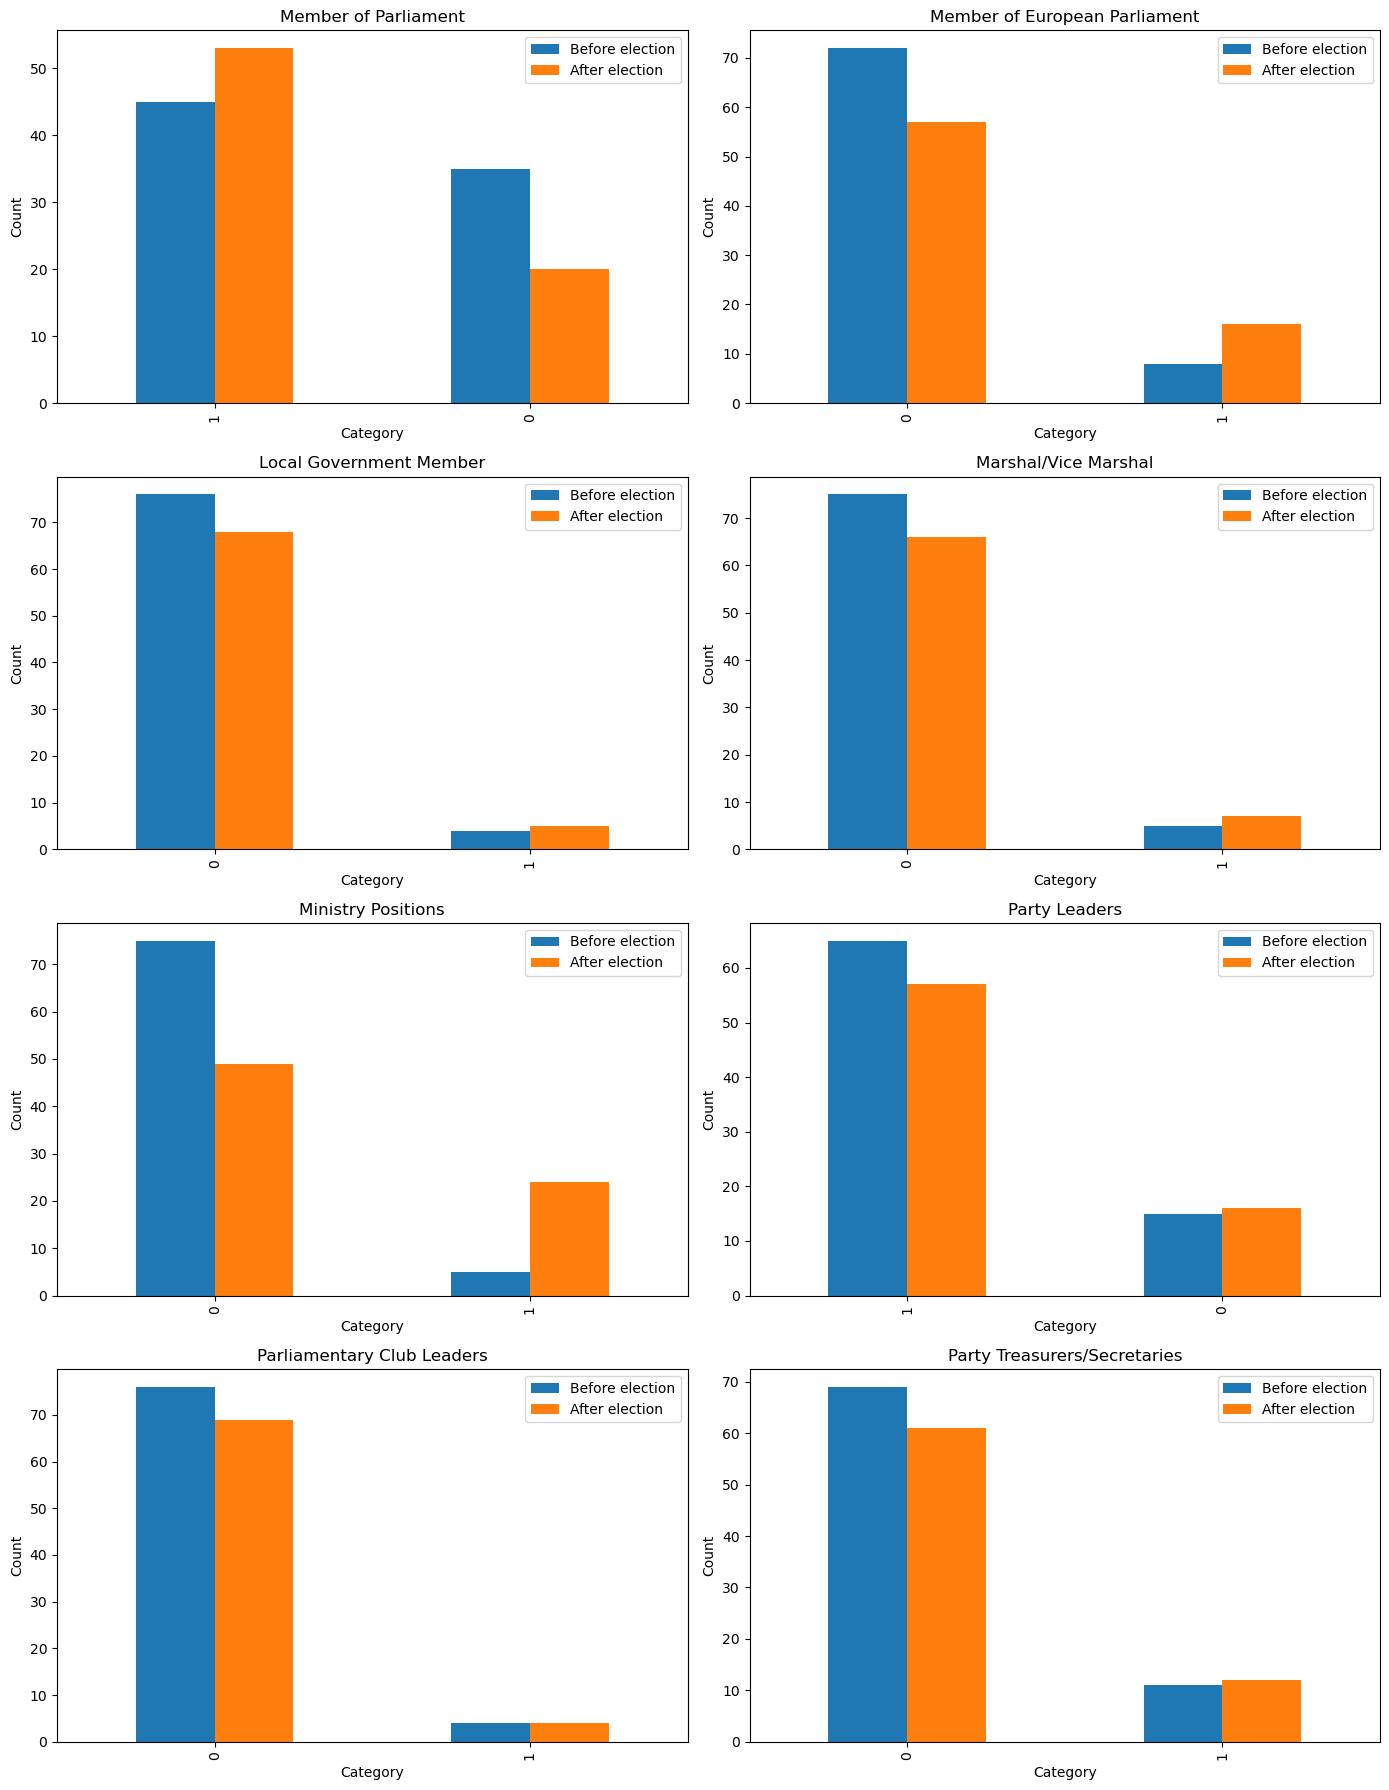

In [98]:
import matplotlib.pyplot as plt
import pandas as pd

column_mapping = {
    'MP_before': 'Member of Parliament',
    'MEP_before': 'Member of European Parliament',
    'LG_member_before': 'Local Government Member',
    'marshall/vicemarshal_before': 'Marshal/Vice Marshal',
    'Positions_in_Ministries_before': 'Ministry Positions',
    'party_presidents/vice_presidents_before': 'Party Leaders',
    'Parliamentary_club_presidents_before': 'Parliamentary Club Leaders',
    'Party_Treasurers_Secretaries_before': 'Party Treasurers/Secretaries'
}

categorical_columns = list(column_mapping.keys())

fig, axes = plt.subplots(4, 2, figsize=(14, 18))
axes = axes.flatten()

for idx, col_before in enumerate(categorical_columns):
    col_after = col_before.replace('_before', '_after')
    
    before_counts = aff_before[col_before].value_counts()
    after_counts = aff_after[col_after].value_counts()
    
    combined = pd.concat([before_counts, after_counts], axis=1, keys=['Before election', 'After election']).fillna(0)

    combined.plot(kind='bar', ax=axes[idx])
    axes[idx].set_title(column_mapping[col_before])
    axes[idx].set_ylabel('Count')
    axes[idx].set_xlabel('Category')
    axes[idx].legend(title='')

plt.tight_layout()
plt.show()

In [100]:
from fuzzywuzzy import process
import pandas as pd

names = df_economic_words['name'].unique()

before_name_mapping = {
    name: process.extractOne(name, aff_before['Name'])[0] for name in names
}

after_name_mapping = {
    name: process.extractOne(name, aff_after['Name'])[0] for name in names
}

df_economic_words['matched_name_before'] = df_economic_words['name'].map(before_name_mapping)
df_economic_words['matched_name_after'] = df_economic_words['name'].map(after_name_mapping)

merged_before = df_economic_words.merge(
    aff_before,
    left_on='matched_name_before',
    right_on='Name',
    how='left',
    suffixes=('', '_before')
)

merged_full = merged_before.merge(
    aff_after,
    left_on='matched_name_after',
    right_on='Name',
    how='left',
    suffixes=('', '_after')
)


/var/folders/4y/59z3xr0d24q8s85gv4mfxhc00000gn/T/ipykernel_9312/1910864902.py:81: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(plot_df['Group'], rotation=45, ha='right')


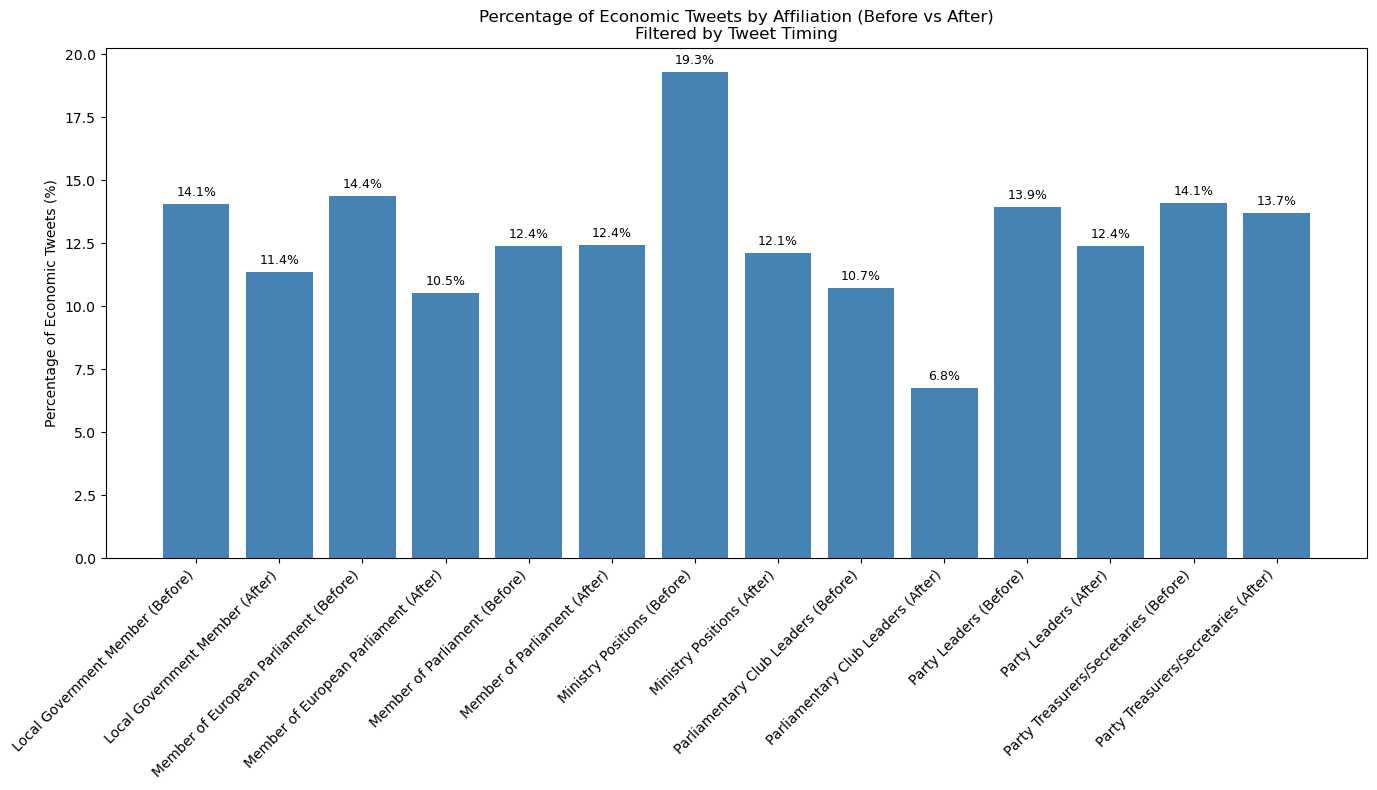

In [109]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure datetime is timezone-aware
merged_full['created_at'] = pd.to_datetime(merged_full['created_at'], utc=True)
cutoff_date = pd.Timestamp("2023-10-15", tz='UTC')

# Define role columns
affiliation_columns = [
    'MP', 'MEP', 'LG_member', 'marshal_vicemarshal',
    'Positions_in_Ministries', 'party_presidents/vice_presidents',
    'Parliamentary_club_presidents', 'Party_Treasurers_Secretaries'
]

# Mapping for pretty labels
affiliation_mapping = {
    'MP': 'Member of Parliament',
    'MEP': 'Member of European Parliament',
    'LG_member': 'Local Government Member',
    'marshal_vicemarshal': 'Marshal/Vice Marshal',
    'Positions_in_Ministries': 'Ministry Positions',
    'party_presidents/vice_presidents': 'Party Leaders',
    'Parliamentary_club_presidents': 'Parliamentary Club Leaders',
    'Party_Treasurers_Secretaries': 'Party Treasurers/Secretaries'
}

records = []

# Loop through roles and time (before/after)
for aff in affiliation_columns:
    for aff_time in ['before', 'after']:
        col = f"{aff}_{aff_time}"
        if col not in merged_full.columns:
            continue

        # Filter by affiliation role
        role_df = merged_full[merged_full[col] == True]

        # Further filter by tweet time based on role time
        if aff_time == 'before':
            time_filtered = role_df[role_df['created_at'] < cutoff_date]
        else:
            time_filtered = role_df[role_df['created_at'] >= cutoff_date]

        total = time_filtered.shape[0]
        econ_count = time_filtered['has_econ_term_FILTERED'].sum()
        percentage = (econ_count / total) * 100 if total > 0 else 0

        records.append({
            'Affiliation': affiliation_mapping[aff],
            'Timing': aff_time.capitalize(),
            'Percentage': percentage
        })

# Create DataFrame for plotting
plot_df = pd.DataFrame(records)
plot_df['Group'] = plot_df['Affiliation'] + ' (' + plot_df['Timing'] + ')'

# Sort for better visual order
plot_df = plot_df.sort_values('Affiliation')

# Plotting
fig, ax = plt.subplots(figsize=(14, 8))
bars = ax.bar(plot_df['Group'], plot_df['Percentage'], color='steelblue')

# Add % labels close to bar top
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.2,
        f'{height:.1f}%',
        ha='center',
        va='bottom',
        fontsize=9
    )

# Styling
ax.set_ylabel('Percentage of Economic Tweets (%)')
ax.set_title('Percentage of Economic Tweets by Affiliation (Before vs After)\nFiltered by Tweet Timing')
ax.set_xticklabels(plot_df['Group'], rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [51]:
df_bert_values = pd.read_parquet('../data/03.cleaned/df_bert_values_GIT.parquet')

print(df_bert_values.head())

  reply_settings                created_at  \
0       everyone 2024-10-15 07:13:34+00:00   
1       everyone 2024-10-14 08:46:51+00:00   
2       everyone 2024-10-13 07:30:58+00:00   
3       everyone 2024-10-12 07:38:50+00:00   
4       everyone 2024-10-11 06:56:29+00:00   

                                         attachments  \
0  {'media_keys': ['3_1846083966849159168', '3_18...   
1                                               None   
2                                               None   
3                                               None   
4                                               None   

                                       edit_controls     author_id  \
0  {'editable_until': '2024-10-15 08:12:39+00:00'...  1.284852e+18   
1  {'editable_until': '2024-10-14 09:43:52+00:00'...  1.284852e+18   
2  {'editable_until': '2024-10-13 08:30:58+00:00'...  1.284852e+18   
3  {'editable_until': '2024-10-12 08:38:50+00:00'...  1.284852e+18   
4  {'editable_until': '2024-10-11 07

In [110]:
# Merge df_bert_values with merged_df to create aff_bert_df
aff_bert_df = merged_full.merge(df_bert_values[['id', 'negative_bert', 'neutral_bert', 'positive_bert']], on='id', how='left')

print(aff_bert_df.head())

                 created_at  \
0 2024-10-15 19:49:34+00:00   
1 2024-10-15 16:12:19+00:00   
2 2024-10-15 12:09:12+00:00   
3 2024-10-15 07:32:44+00:00   
4 2024-10-15 06:27:14+00:00   

                                                text                   id  \
0  @donaldtusk Niezrealizowanie większości ze "10...  1846277256509116672   
1  Rok po wyborach trzeba powiedzieć jedno - nie ...  1846222583898784000   
2   ❌ Mamy rok po wyborach, a Polska pogrąża się ...  1846161400328028160   
3  Mija rok od wyborów parlamentarnych. W kampani...  1846091824101769472   
4              #Idę11  🇵  🇱  https://t.co/KiCe5ATOpX  1846075343188144128   

      author_id                                      edit_controls  \
0  1.182212e+09  {'editable_until': '2024-10-15 20:49:34+00:00'...   
1  1.182212e+09  {'editable_until': '2024-10-15 17:12:19+00:00'...   
2  1.182212e+09  {'editable_until': '2024-10-15 13:09:12+00:00'...   
3  1.182212e+09  {'editable_until': '2024-10-15 08:32:44+00:00'...   
